In [119]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2B3, Xception

In [120]:
IMAGE_WIDTH = 299
IMAGE_HEIGHT = 299
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 15
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
TRAIN_DIRECTORY = "big-files/train/"
TEST_DIRECTORY = "big-files/test/"
VALIDATION_DIRECTORY = "big-files/validation/"
CLASS_LABELS = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
# классы


In [121]:
test_directory = os.listdir(TEST_DIRECTORY)

In [122]:
# Создаем списки для хранения данных
filename = []
labels = []

# Проходим по каждому классу и добавляем данные в списки
def create_dataframe(data_dir, class_labels):
    for category, label in class_labels.items():
        category_path = os.path.join(data_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            filename.append(img_path)
            labels.append(label)
    
# создаем DataFrame
    return pd.DataFrame ({
        "filename": filename,
        "category": labels
        })

In [123]:
df = create_dataframe(TRAIN_DIRECTORY, CLASS_LABELS)
df_validation = create_dataframe(VALIDATION_DIRECTORY, CLASS_LABELS)

test_df = pd.DataFrame({
    "filename": test_directory
})

<Axes: xlabel='category'>

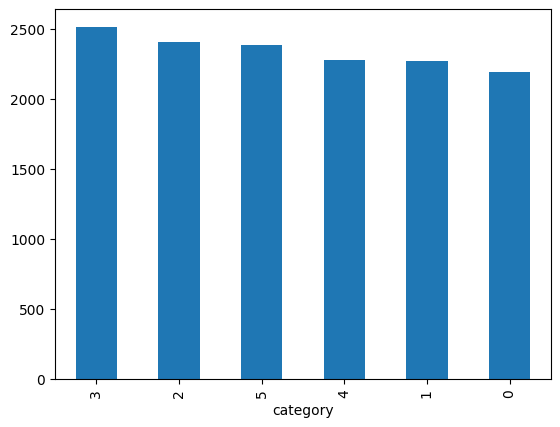

In [124]:
df["category"].value_counts().plot.bar()

In [125]:
# Функция для создания предобученной модели
def create_model(base_model, input_shape, model_name):
    model = base_model(weights="imagenet", include_top=False, input_shape=input_shape)
    model.trainable = False # замораживаем все
    return model

In [126]:
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
xception = create_model(Xception, input_shape, 'xception')
efficientnetv2b3 = create_model(EfficientNetV2B3, input_shape, 'efficientnetv2b3')

In [127]:
df['category'] = df['category'].astype(str)
df_validation['category'] = df_validation['category'].astype(str)

In [128]:
# Создаем входной слой
input_layer = Input(shape=input_shape, name='input_layer')

In [129]:
# Пропускаем входной слой через каждую предобученную модель
xception_output = xception(input_layer)
efficientnetv2b3_output = efficientnetv2b3(input_layer)

In [130]:
# Получаем выходы каждой модели
xception_output = Flatten()(xception_output)
efficientnetv2b3_output = Flatten()(efficientnetv2b3_output)

In [131]:
merged_output = Concatenate()([efficientnetv2b3_output, xception_output])

In [132]:
dense_layer = Dense(256, activation='relu')(merged_output)
dropout_layer = Dropout(0.4)(dense_layer)
output_layer = Dense(6, activation='softmax')(dropout_layer)

In [133]:
final_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [134]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # для нормализации пикселей изображения в диапазоне [0, 1].
    rotation_range=20, # для легкой ротации изображения
    shear_range=0.2, # сдвиг угла
    zoom_range=0.2, # масштабирование
    horizontal_flip=True, # горизонтальный поворот
    vertical_flip=True, # вертикальный поворот
    width_shift_range=0.2, # сдвиг по горизонтали
    height_shift_range=0.2, # сдвиг по вертикали
    brightness_range=(0.8, 1.2), # изменение яркости
    fill_mode='nearest', # для заполнения пикселей за пределами границ
)

In [135]:
val_datagen = ImageDataGenerator(
    rescale=1/255
)

In [136]:
test_datagen = ImageDataGenerator(
    rescale=1./255 
    )

In [137]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='categorical',
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df_validation,
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = True,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIRECTORY,
    x_col="filename",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
)

Found 14034 validated image filenames belonging to 6 classes.
Found 17034 validated image filenames belonging to 6 classes.
Found 7301 validated image filenames.


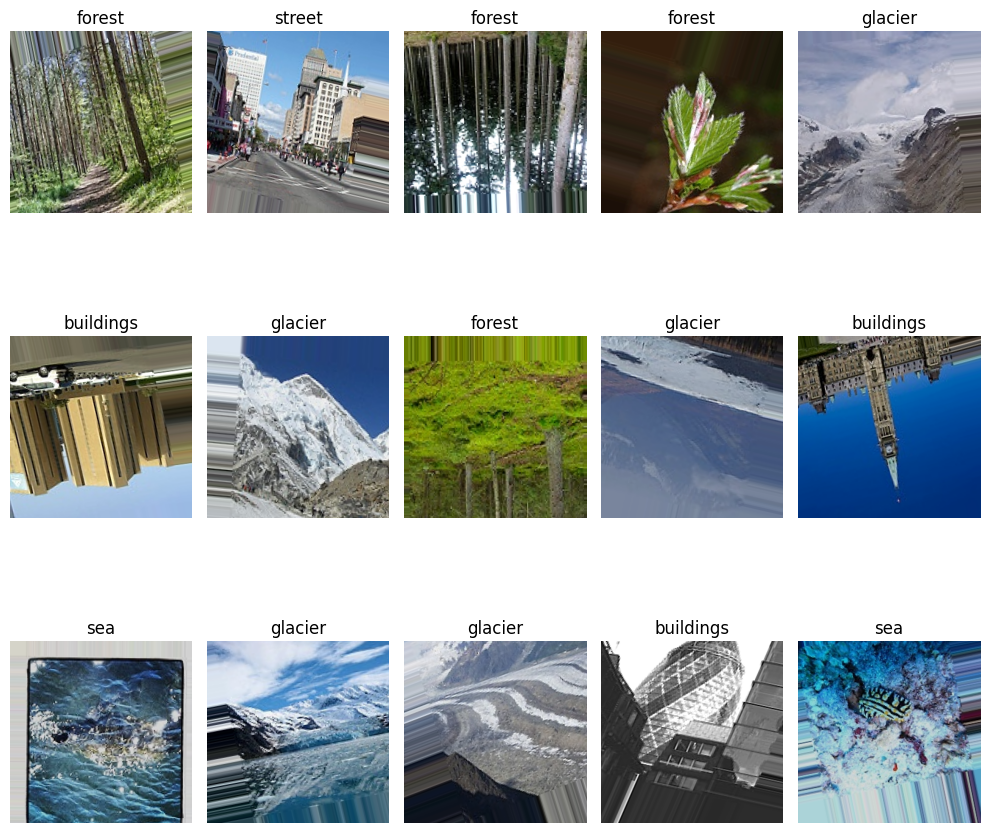

In [138]:
# Создаем обратный словарь
reverse_class_labels = {v: k for k, v in CLASS_LABELS.items()}

fig, axes = plt.subplots(3, 5, figsize=(10, 10))
for i in range(3):
    for j in range(5):
        images, labels = next(train_generator)
        axes[i, j].imshow(images[0])
        axes[i, j].axis('off')
        label_idx = np.argmax(labels[0])
        label_name = reverse_class_labels[label_idx]
        axes[i, j].set_title(label_name)
        
plt.tight_layout()
plt.show()

In [139]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)


earlystop = EarlyStopping(patience = 5)
    
callbacks = [earlystop, learning_rate_reduction]

In [140]:
final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

In [141]:
history = final_model.fit(
    train_generator, 
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator) // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // BATCH_SIZE,
)

Epoch 1/15


c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - acc: 0.2001 - loss: 76.6434 - val_acc: 0.4297 - val_loss: 20.6313
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - acc: 0.3912 - loss: 28.1297 - val_acc: 0.6953 - val_loss: 2.9347
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - acc: 0.5339 - loss: 4.1353 - val_acc: 0.5879 - val_loss: 1.0657
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - acc: 0.3985 - loss: 1.5475 - val_acc: 0.5840 - val_loss: 1.0313
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - acc: 0.4294 - loss: 1.3845 - val_acc: 0.6641 - val_loss: 0.8469
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - acc: 0.5521 - loss: 1.1399 - val_acc: 0.6504 - val_loss: 0.8695
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - acc: 0.5015 - loss: 1.2134 - val_acc: 0.6875 - val_loss: 0.8793
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - acc: 0.5547 - loss: 1.2186 - val_acc: 0.6777 - val_loss: 0.8994
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - acc: 0.5377 - loss: 1.1345 

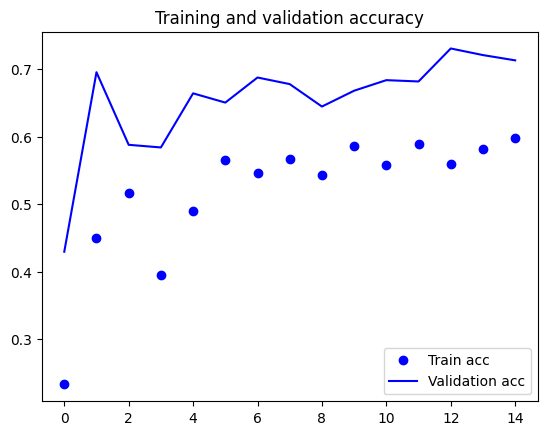

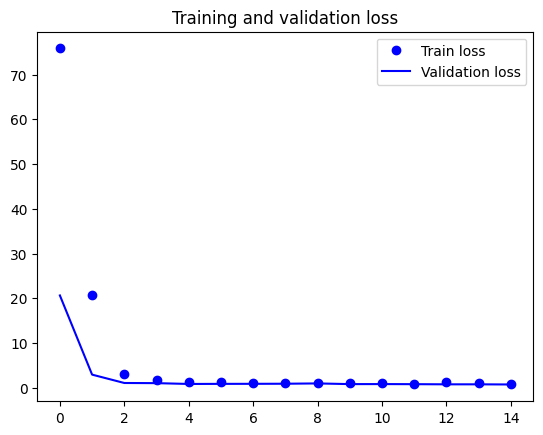

In [142]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(acc, 'bo', label='Train acc')
plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, 'bo', label='Train loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [144]:
pred = final_model.predict(test_generator)

c:\Users\ivanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


229/229 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step


In [145]:
predicted_classes = np.argmax(pred, axis=1)

In [146]:
test_df["category"] = predicted_classes

<Axes: xlabel='category'>

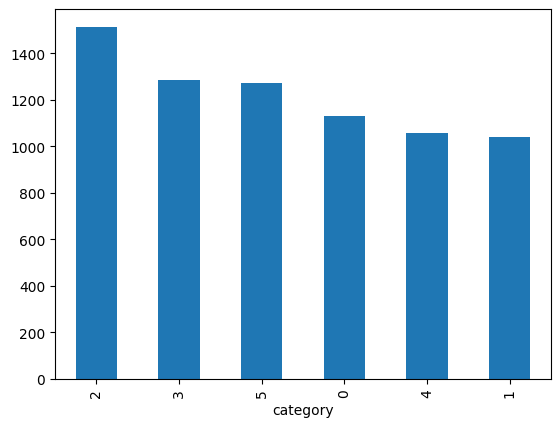

In [150]:

test_df["category"].value_counts().plot.bar()

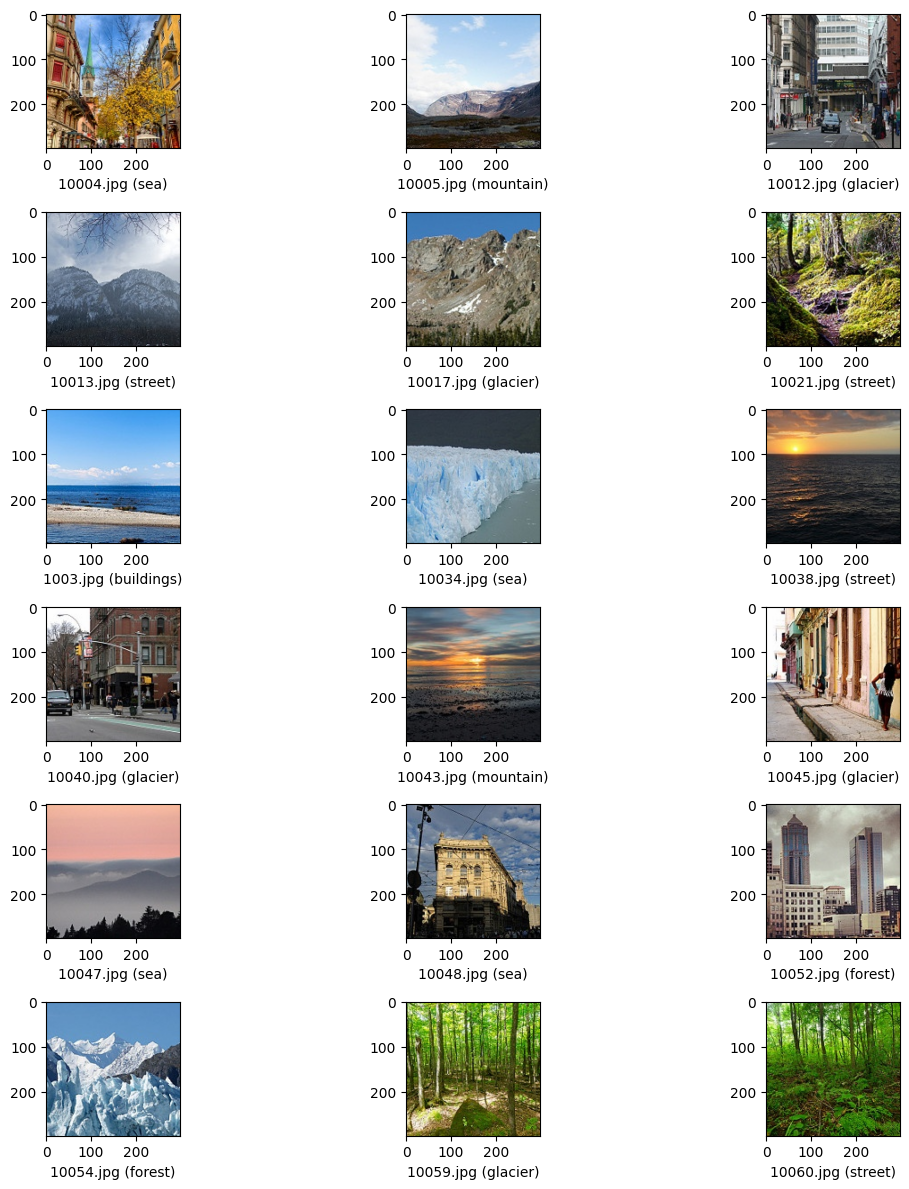

In [148]:
# Преобразование категорий в числовые значения



sample_test = test_df.head(18)
reverse_category_mapping = {v: k for k, v in CLASS_LABELS.items()}  # Создание обратного словаря
sample_test.loc[:, 'category'] = sample_test.loc[:, 'category'].replace(CLASS_LABELS)

plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = image.load_img(TEST_DIRECTORY + filename, target_size = IMAGE_SIZE)
    plt.subplot(6, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(filename + ' (' + reverse_category_mapping[category] + ')')
plt.tight_layout()
plt.show()